Columns in dataset: Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')
Categorical Columns: Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object')


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

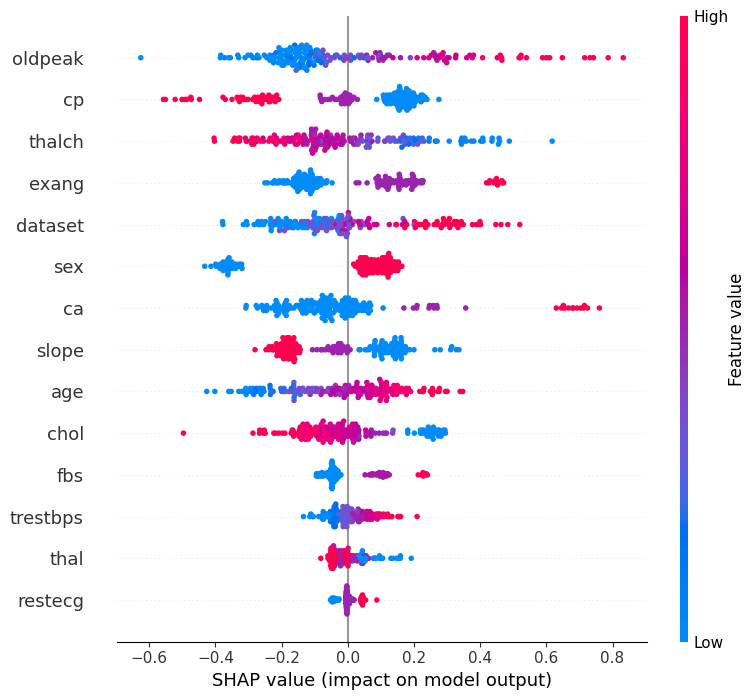

<Figure size 640x480 with 0 Axes>

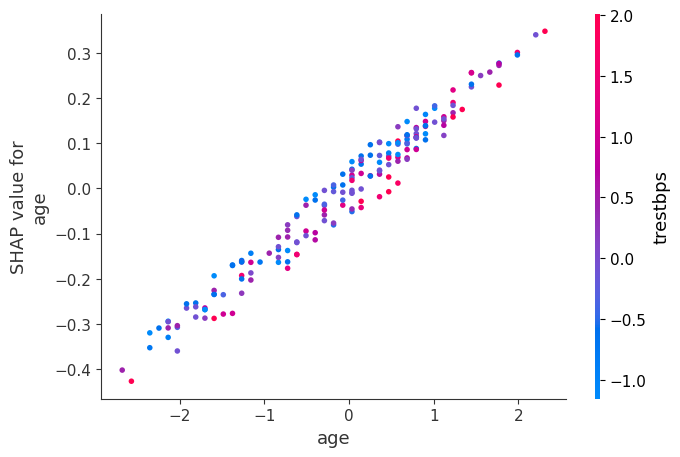

In [9]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer  # For handling NaN values

# Load dataset
url = "/content/heart1.csv"

# Try different separators based on dataset structure
try:
    df = pd.read_csv(url)  # Default delimiter
except Exception as e:
    print("Error loading with default separator, trying semicolon (;)")
    df = pd.read_csv(url, sep=";")

# Display column names
print("Columns in dataset:", df.columns)

# Set target column
target_column = "num"

# Ensure target column exists
if target_column not in df.columns:
    raise KeyError(f"Column '{target_column}' not found! Available columns: {df.columns}")

# Convert categorical features to numeric
categorical_columns = df.select_dtypes(include=["object"]).columns
print("Categorical Columns:", categorical_columns)

# Apply Label Encoding to categorical features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle missing values (replace NaNs with column median)
imputer = SimpleImputer(strategy="median")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Separate features and target
X = df.drop(columns=[target_column], axis=1)
y = df[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Initialize SHAP LinearExplainer
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="correlation_dependent")

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Convert SHAP values into DataFrame
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# SHAP Summary Plot
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Dependence Plot for the first feature
plt.figure()
shap.dependence_plot(X.columns[0], shap_values, X_test, feature_names=X.columns)

# Force Plot for the first instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], feature_names=X.columns)
